Based on the code for `./output_investigation_07.ipynb`.
Make four plots
1. Convergence plots of suboptimizations
2. Feasibility criterion
3. Globally averaged weights
4. Monthly weigh maps

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pickle
from scipy import stats

In [2]:
from generate_opt_objects import A_b_generation

**PNC:/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


In [3]:
import matplotlib

# matplotlib settings
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rc('text.latex', preamble=r'\usepackage{bm}')

In [4]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# save filepath
SAVE_FIG_BASE = '../figures/interval_optimizations/continental_US_jun2010/dual/08'

# plotting directory
IMAGE_PATH = '/Users/mikestanley/Research/Carbon_Flux/optimization/figures/final_images'

In [5]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

In [6]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open('../fixed_optimization_inputs/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl'
)

FUNC_FP = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP += '/src_admm/data/carbon_flux/objects/na_june_functional.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)

In [7]:
# psi_alpha
with open('./data/carbon_flux/objects/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
    
PSI_ALPHA = np.sqrt(stats.chi2.ppf(q=.95, df=1) + opt_slack[1])

In [8]:
def f_w(w, y=y_tilde, psi_alpha=PSI_ALPHA, b=b, c=np.zeros_like(b)):
    """ Lower endpoint functional """
    return np.dot(w, y) - psi_alpha * np.linalg.norm(w) - np.dot(b, c)

def f_w_uep(w, y=y_tilde, psi_alpha=PSI_ALPHA, b=b, c=np.zeros_like(b)):
    """ Lower endpoint functional """
    return -np.dot(w, y) + psi_alpha * np.linalg.norm(w) + np.dot(b, c)

# Plotting Functions

In [9]:
def global_avg_plot(w_ser, title_str=None, figsize=(8, 5)):
    """
    Globally averaged weights at daily, weekly, and month res
    
    Parameters
    ----------
        w_ser (pandas series) : weights indexed by time
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ts_day = w_ser.resample('D').mean()
    ts_week = w_ser.resample('W').mean()
    ts_month = w_ser.resample('M').mean()
    ts_day.plot(ax=ax, label='Day')
    ts_week.plot(ax=ax, label='Week')
    ts_month.plot(ax=ax, label='Month')
    ax.axhline(0, linestyle='--', color='gray')
    ax.legend()
    ax.set_title(title_str)
    plt.show()
    
def month_map_plot(df, w_col_str, norm, vmin=None, vmax=None, figsize=(12, 16), save_fp=None):
    """
    Monthly heat maps for the given weights
    
    Parameters
    ----------
        df        (pandas dataframe)  : contains columns - 'month', 'lon', 'lat', and w_col_str
        w_col_str (str)               : name of w column in df to use
        norm      (mcolors.Normalize) : for color scheme
    """
    # w start
    fig, ax = plt.subplots(ncols=2, nrows=4, figsize=figsize)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

    for i in range(8):
        row_idx = i // 2
        col_idx = i % 2
        month_idxs = df['month'].astype(int) == i + 1
        sp_i = ax[row_idx, col_idx].scatter(
            df['lon'][month_idxs], df['lat'][month_idxs],
            c=df[w_col_str][month_idxs],
            norm=norm, vmin=vmin, vmax=vmax,
            s=14, cmap='seismic'
        )
        ax[row_idx, col_idx].set_title(months[i])

    plt.colorbar(sp_i,ax=ax[0, 0])
    if save_fp:
        plt.savefig(save_fp, dpi=300)
        plt.close()
    else:
        plt.show()

# Optimization Diagnostics

#### Convergence Plots

In [10]:
# read in the raw stdout file
with open(BASE_DIR + '/08/stdout_it0.txt', 'r') as f:
    stdout0_raw = f.readlines()

In [11]:
# isolate the trajectories from the w optimization
all_obj_vals = [float(line[22:34].replace('D', 'e')) for line in stdout0_raw if 'At iterate' in line]
traj_w_01 = all_obj_vals[:13]
traj_c_01 = all_obj_vals[13:16]
traj_w_02 = all_obj_vals[16:29]
traj_c_02 = all_obj_vals[29:32]
traj_w_03 = all_obj_vals[32:45]
traj_c_03 = all_obj_vals[45:48]
traj_w_04 = all_obj_vals[48:61]
traj_c_04 = all_obj_vals[61:64]
traj_w_05 = all_obj_vals[64:77]
traj_c_05 = all_obj_vals[77:80]
traj_w_06 = all_obj_vals[80:93]
traj_c_06 = all_obj_vals[93:96]
traj_w_07 = all_obj_vals[96:109]
traj_c_07 = all_obj_vals[109:112]
traj_w_08 = all_obj_vals[112:125]
traj_c_08 = all_obj_vals[125:128]
traj_w_09 = all_obj_vals[128:141]
traj_c_09 = all_obj_vals[141:144]
traj_w_10 = all_obj_vals[144:157]
traj_c_10 = all_obj_vals[157:]

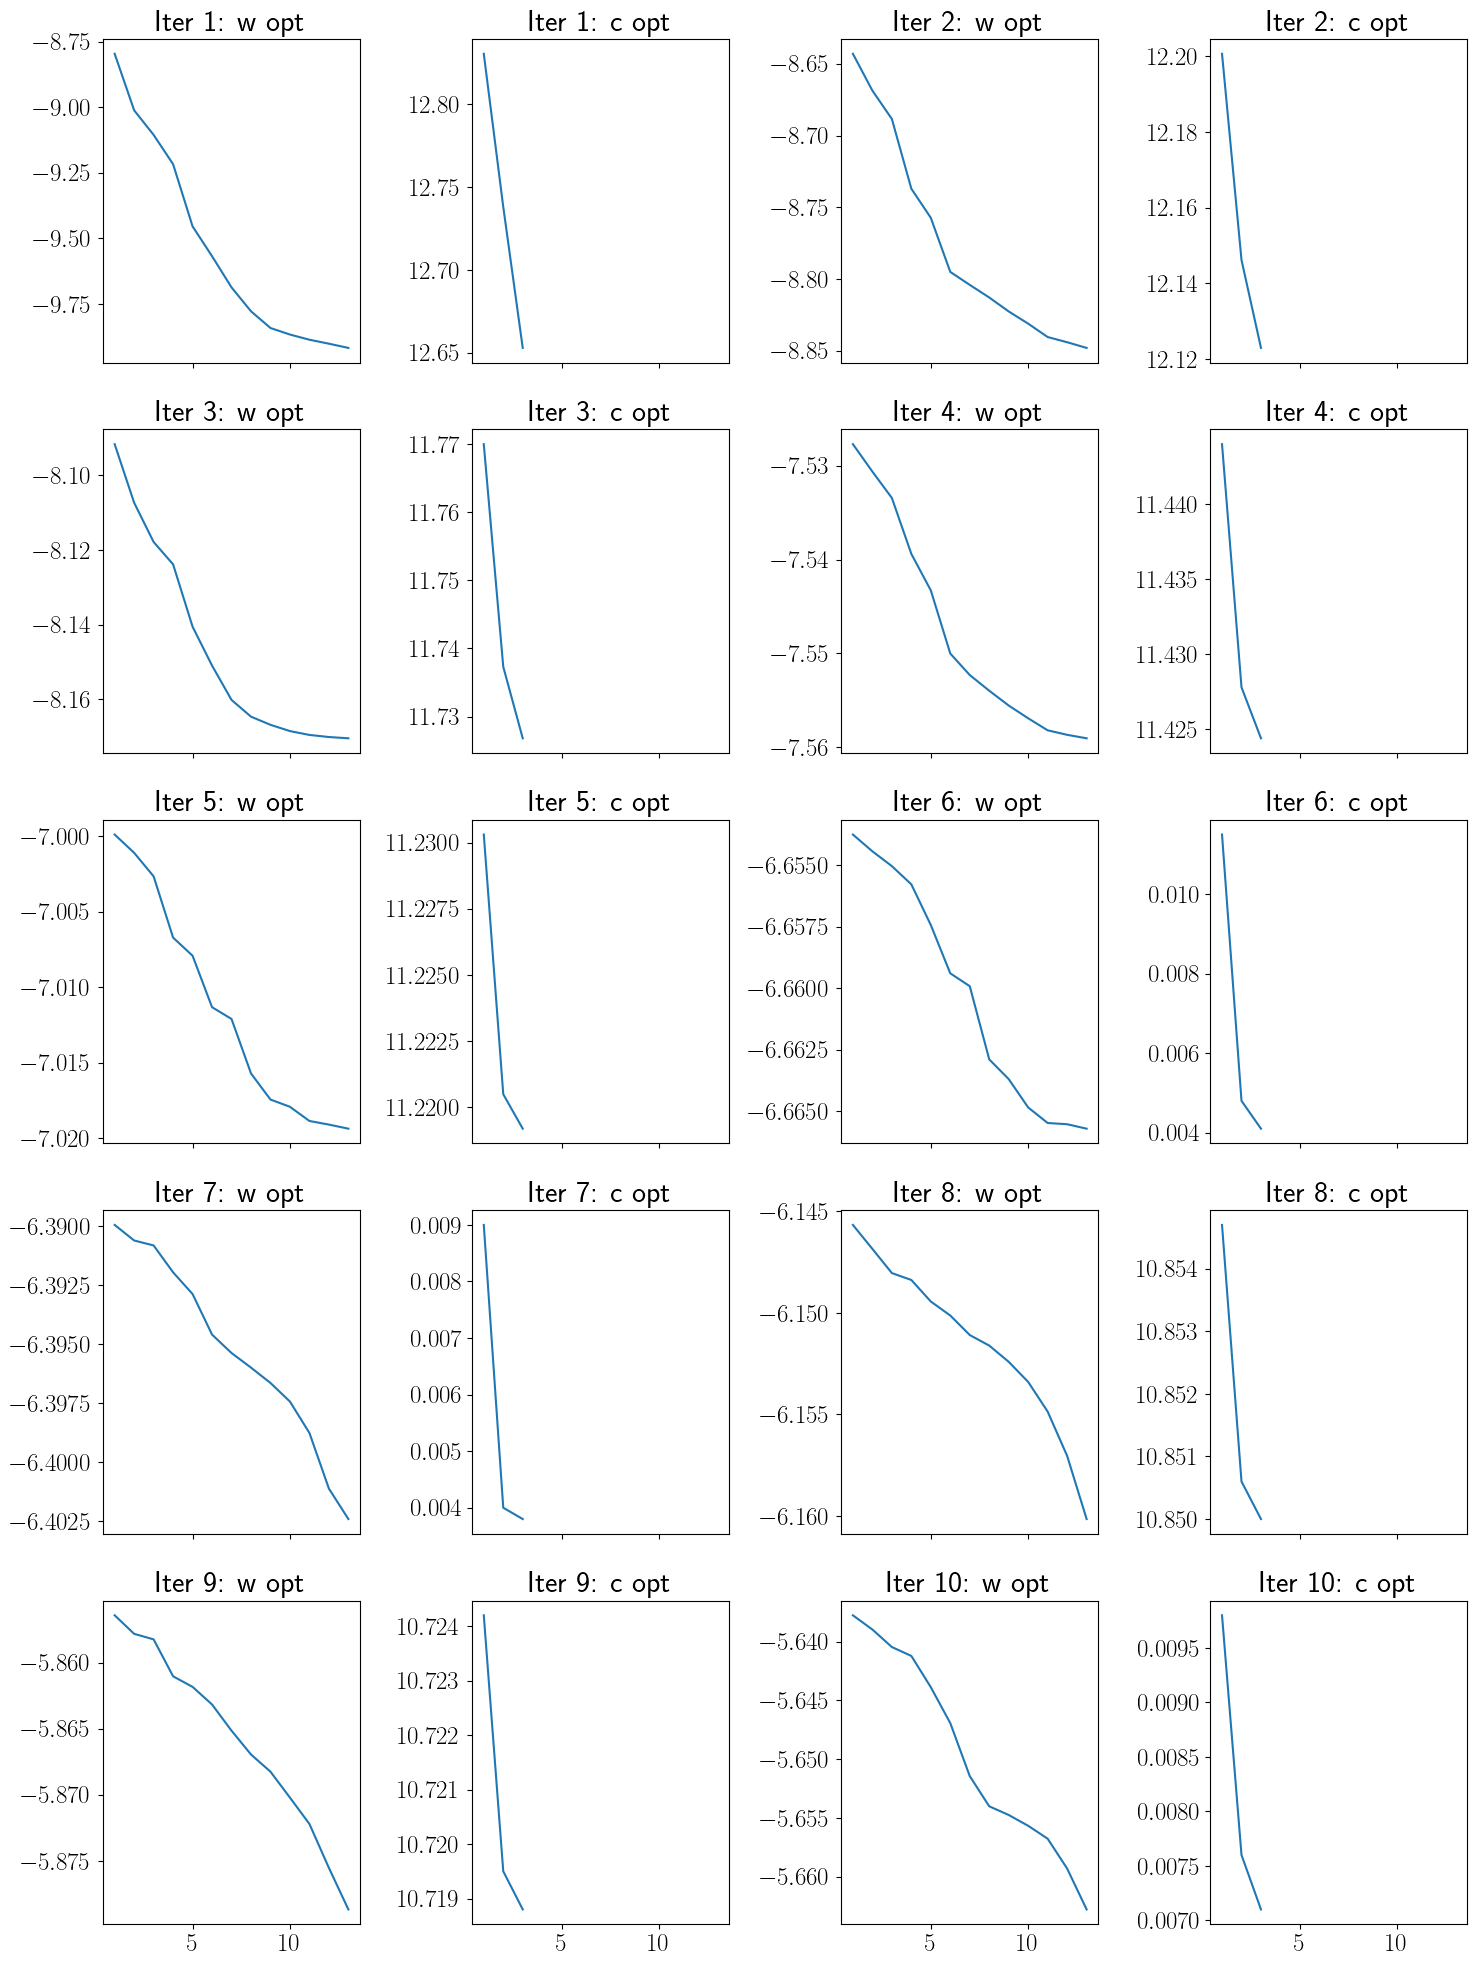

In [16]:
fig, ax = plt.subplots(ncols=4, nrows=5, figsize=(15, 20), sharex=True)

# iteration 1
ax[0, 0].plot(np.arange(1, len(traj_w_01) + 1), traj_w_01)
ax[0, 1].plot(np.arange(1, len(traj_c_01) + 1), traj_c_01)

# iteration 2
ax[0, 2].plot(np.arange(1, len(traj_w_02) + 1), traj_w_02)
ax[0, 3].plot(np.arange(1, len(traj_c_02) + 1), traj_c_02)

# # iteration 3
ax[1, 0].plot(np.arange(1, len(traj_w_03) + 1), traj_w_03)
ax[1, 1].plot(np.arange(1, len(traj_c_03) + 1), traj_c_03)

# # iteration 4
ax[1, 2].plot(np.arange(1, len(traj_w_04) + 1), traj_w_04)
ax[1, 3].plot(np.arange(1, len(traj_c_04) + 1), traj_c_04)

# # iteration 5
ax[2, 0].plot(np.arange(1, len(traj_w_05) + 1), traj_w_05)
ax[2, 1].plot(np.arange(1, len(traj_c_05) + 1), traj_c_05)

# # iteration 6
ax[2, 2].plot(np.arange(1, len(traj_w_06) + 1), traj_w_06)
ax[2, 3].plot(np.arange(1, len(traj_c_06) + 1), traj_c_06)

# # iteration 7
ax[3, 0].plot(np.arange(1, len(traj_w_07) + 1), traj_w_07)
ax[3, 1].plot(np.arange(1, len(traj_c_07) + 1), traj_c_07)

# # iteration 8
ax[3, 2].plot(np.arange(1, len(traj_w_08) + 1), traj_w_08)
ax[3, 3].plot(np.arange(1, len(traj_c_08) + 1), traj_c_08)

# # iteration 9
ax[4, 0].plot(np.arange(1, len(traj_w_09) + 1), traj_w_09)
ax[4, 1].plot(np.arange(1, len(traj_c_09) + 1), traj_c_09)

# # iteration 10
ax[4, 2].plot(np.arange(1, len(traj_w_10) + 1), traj_w_10)
ax[4, 3].plot(np.arange(1, len(traj_c_10) + 1), traj_c_10)


# labels
ax[0, 0].set_title('Iter 1: w opt')
ax[0, 1].set_title('Iter 1: c opt')
ax[0, 2].set_title('Iter 2: w opt')
ax[0, 3].set_title('Iter 2: c opt')
ax[1, 0].set_title('Iter 3: w opt')
ax[1, 1].set_title('Iter 3: c opt')
ax[1, 2].set_title('Iter 4: w opt')
ax[1, 3].set_title('Iter 4: c opt')
ax[2, 0].set_title('Iter 5: w opt')
ax[2, 1].set_title('Iter 5: c opt')
ax[2, 2].set_title('Iter 6: w opt')
ax[2, 3].set_title('Iter 6: c opt')
ax[3, 0].set_title('Iter 7: w opt')
ax[3, 1].set_title('Iter 7: c opt')
ax[3, 2].set_title('Iter 8: w opt')
ax[3, 3].set_title('Iter 8: c opt')
ax[4, 0].set_title('Iter 9: w opt')
ax[4, 1].set_title('Iter 9: c opt')
ax[4, 2].set_title('Iter 10: w opt')
ax[4, 3].set_title('Iter 10: c opt')

for i in range(5):
    for j in range(4):

        # rotate tick labele
#         ax[i, j].tick_params(axis='x', labelrotation=90)

        # remove offset axis text
        ax[i, j].yaxis.offsetText.set_visible(False)

plt.tight_layout()
plt.savefig(IMAGE_PATH + '/dual_suboptimization_convergence.png', dpi=300)
plt.show()

#### Final results

In [12]:
with open(BASE_DIR + '/08/final_results.pkl', 'rb') as f:
    final_res = pickle.load(f)

In [13]:
final_res

{'objective_evals': [-1.5488606856118126,
  -1.9926673655729024,
  -2.2689652542069525,
  -2.465041127338004,
  -2.6824705746119006,
  -2.977937204006982,
  -3.1827686962811477,
  -3.2433650365672966,
  -3.460440038926837,
  -3.4492964972046596],
 'w_opt_output': {'vectors': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.91919704e-06,  3.21529329e-05,  3.32435048e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           2.26346087e-05,  7.21158821e-05,  3.51222037e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           4.24866725e-05,  1.00957569e-04,  3.61033092e-03],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.07751980e-04,  1.84294753e-04,  3.48017497e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.20174301e-04,  1.98900189e-04,  3.30276673e-03],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
      

In [14]:
# read in the results from run 07 to compare
with open(BASE_DIR + '/07/final_results.pkl', 'rb') as f:
    final_res_07 = pickle.load(f)
    
x_vals_07 = np.arange(1, 11)
obj_vals_07 = final_res_07['objective_evals']

# compute feasibility
feasibility_07 = np.zeros(10)
for i in range(0, 10):
    feasibility_07[i] = np.linalg.norm(
        h + A.T @ final_res_07['c_opt_output']['vectors'][i] - final_res['KTw_vecs'][i]
    )

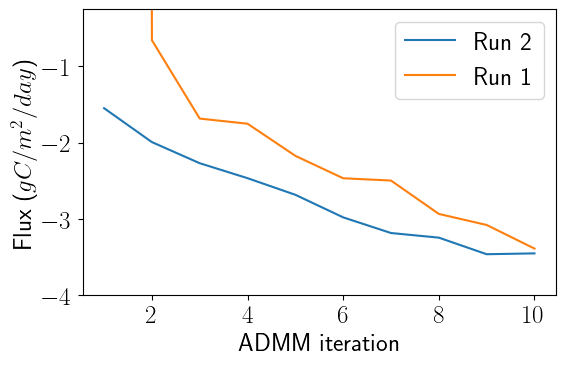

In [15]:
plt.figure(figsize=(6, 4))
x_vals = np.arange(1, 11)
obj_vals = final_res['objective_evals']

# 08 numbers
plt.plot(x_vals, obj_vals, label='Run 2')
# plt.scatter(x_vals, obj_vals)

# 07 numbers
plt.plot(x_vals_07, obj_vals_07, label='Run 1')
# plt.scatter(x_vals_07, obj_vals_07)

# plt.axhline(-3.665, linestyle='--', label='SSB LEP', color='red')
# plt.axhline(-2.478, linestyle='--', label='OSB LEP', color='blue')
# plt.axhline(-0.436, linestyle='--', label='True functional value', color='gray')
plt.legend()
plt.xlabel('ADMM iteration')
plt.ylabel('Flux ($gC/m^{2}/day$)')
plt.ylim(-4, -0.25)
plt.tight_layout()
plt.savefig(IMAGE_PATH + '/dual_optimality.png', dpi=300)

plt.show()

In [16]:
# get feasibility values for other iterations
IDX = 10
feasibility_08 = np.zeros(IDX)
for i in range(0, IDX):
    feasibility_08[i] = np.linalg.norm(h + A.T @ final_res['c_opt_output']['vectors'][i] - final_res['KTw_vecs'][i])

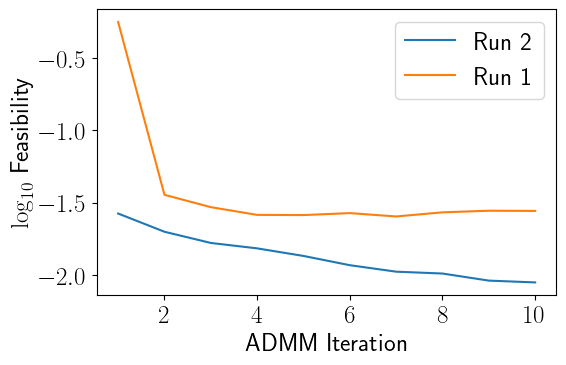

In [42]:
# plot feasility valies
plt.figure(figsize=(6, 4))
plt.plot(x_vals, np.log10(feasibility_08), label='Run 2')
# plt.scatter(x_vals, np.log10(feasibility_08))

plt.plot(x_vals_07, np.log10(feasibility_07), label='Run 1')
# plt.scatter(x_vals_07, np.log10(feasibility_07))

# plt.axhline(0, linestyle='--', color='gray')
plt.legend()

plt.xlabel('ADMM Iteration')
# plt.ylabel(r'Feasibility - $\log || \bm{h} + \bm{A}^T \bm{c}_k - \bm{K}^T \bm{w}_k ||_2$')
plt.ylabel(r'$\log_{10}$ Feasibility')
# plt.title(r'Feasibility criterion values: $\log || h + A^T c_k - K^T w_k ||_2$')
plt.tight_layout()
plt.savefig(IMAGE_PATH + '/dual_feasibility.png', dpi=300)
plt.show()

# Dual variable visualization

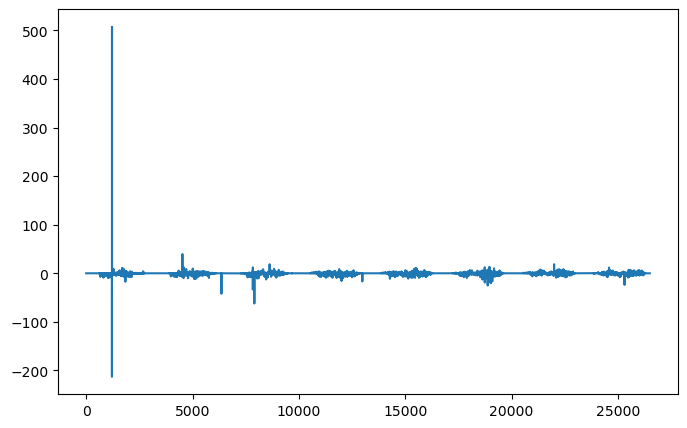

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(final_res['lambda_opt_output']['vectors'][-1])
plt.show()

#### Forward model input

I.e.,
\begin{equation}
\lambda_k - \mu (K^T w_k - h - A^T c_k)
\end{equation}

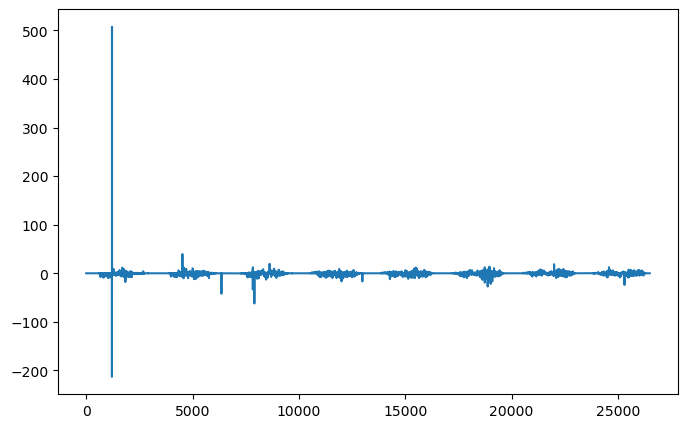

In [20]:
lambda_k = final_res['lambda_opt_output']['vectors'][-1]
KTw_k = final_res['KTw_vecs'][-1]
c_k = final_res['c_opt_output']['vectors'][-1]
forward_mod_input = lambda_k - 1e3 * (KTw_k - h - A.T @ c_k)

plt.figure(figsize=(8, 5))
plt.plot(forward_mod_input)
plt.show()

# Weight plots

In [34]:
# read in the starting w used
with open('./data/carbon_flux/results/08/intermediate_starts/w_start_it0.npy', 'rb') as f:
    w_start = np.load(file=f)

In [35]:
# add columns to the gosat dataframe
gosat_df['w_start'] = w_start

LAST_IDX = 10
for i in range(LAST_IDX):
    
    # weights
    gosat_df[f'w_admm{i}'] = final_res['w_opt_output']['vectors'][i]
    
    # w y prods
    gosat_df[f'w_y_prods{i}'] = gosat_df[f'w_admm{i}'] * y_tilde

In [36]:
# create a datetime column for the observations
gosat_df['time'] = gosat_df.apply(
    lambda x: pd.to_datetime(f"{int(x['day'])}/{int(x['month'])}/{int(x['year'])}", format="%d/%m/%Y"),
    axis=1
)

# set the above as the index
gosat_df.set_index('time', inplace=True)

#### Global Average Weights

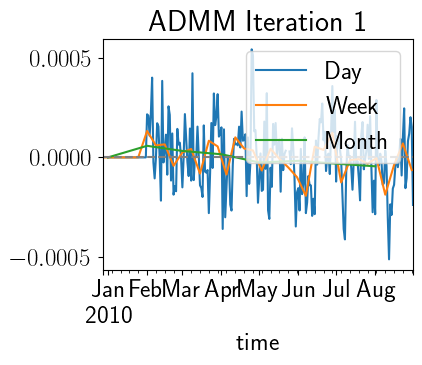

In [37]:
global_avg_plot(w_ser=gosat_df['w_admm9'], title_str=r'ADMM Iteration 1', figsize=(4, 3))

#### Heat Maps

In [38]:
# define a color scheme
norm_start = mcolors.Normalize(
    vmin=gosat_df['w_start'].min(),
    vmax=gosat_df['w_start'].max(),
)
norm = mcolors.Normalize(
    vmin=gosat_df[['w_start', 'w_admm0']].values.flatten().min(),
    vmax=gosat_df[['w_start', 'w_admm0']].values.flatten().max(),
)

In [39]:
# product maps
for i in range(10):
    SAVE_FP = SAVE_FIG_BASE + '/w_y_prods%s.png' % str(i).zfill(2)
    month_map_plot(
        df=gosat_df, w_col_str=f'w_y_prods{i}', norm=None, vmin=-0.06, vmax=0.06,
        save_fp=SAVE_FP
    )

In [33]:
# heat map of start
SAVE_FP = SAVE_FIG_BASE + '/w_start.png'
month_map_plot(
    df=gosat_df, w_col_str='w_start', norm=None, vmin=-0.001, vmax=0.001,
    save_fp=SAVE_FP
)

In [40]:
# after current ADMM iterations
for i in range(10):
    SAVE_FP = SAVE_FIG_BASE + '/w_admm%s.png' % str(i).zfill(2)
    month_map_plot(
        df=gosat_df, w_col_str=f'w_admm{i}', norm=None, vmin=-0.01, vmax=0.01,
        save_fp=SAVE_FP
    )